In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import pickle
import difflib
from collections import Counter
from  pprint import pprint

%matplotlib inline

import re
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import log_loss


#############data loading

train = pd.read_csv('train.csv', sep=',', header=0)
test = pd.read_csv('test.csv', sep=',', header=0)

train = train.fillna(" ")
test = test.fillna(" ")
print(train.shape)
train.head(2)

[nltk_data] Downloading package stopwords to /home/tom/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tom/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [2]:
stop_words = set(stopwords.words('english'))

tfidf = TfidfVectorizer(ngram_range=(1, 1),min_df=50)
tfidf.fit(np.concatenate([train.question1.values,train.question2.values],axis=0))

def sequence_match(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()

#gets a pandas row with specific column names!
def noun_match_ratio(row):
    if(row.z_noun_match == 0): 
        return 0
    else:
        return row.z_noun_match / ((len(row.question1_nouns)+len(row.question2_nouns))/2)

def noun_extracter(sentence):
    tokens = nltk.word_tokenize(sentence.lower())
    return np.array([w for w, t in nltk.pos_tag(tokens) if t[:1] in ['N']])
    
def word_match(q1,q2):
    q1 = q1.split()
    q2 = q2.split()
    if(len(q1) == 0 or len(q2) == 0):
        return 0
    else:
        both = set(q1).intersection(set(q2))
        return len(both) * 2 / (len(q1) + len(q2))
    

def stopWordsRemover(phrase):
    bla = [w for w in str(phrase).lower().split() if w not in stop_words]
    return " ".join(bla)


class LemmaTokenizer(object):
    def __init__(self):
        self.snbstem = SnowballStemmer('english')
    def lemmatizeWithoutPunkt(self,doc):
        doc = re.sub('[?.,!():]',"",doc)
        temp = [self.snbstem.stem(t) for t in doc.lower().split()]
        return " ".join(temp)

def substitute_thousands(text):
    matches = re.finditer(r'[0-9]+(?P<thousands>\s{0,2}k\b)', text, flags=re.I)
    result = ''
    len_offset = 0
    for match in matches:
        result += '{}000'.format(text[len(result)-len_offset:match.start('thousands')])
        len_offset += 3 - (match.end('thousands') - match.start('thousands'))
    result += text[len(result)-len_offset:]
    return result

def convertPredictions(preds):
    a = 0.165 / 0.37 
    b = (1 - 0.165) / (1 - 0.37)

    return (preds * a)  / (preds * a + (1 - preds) * b)

print("done loading fcts")

done loading fcts


In [3]:
def getFeatures(df):
    print("get basic length/match features")
    df.loc[:,'question1'] = df.question1.map(lambda x: substitute_thousands(x))
    df.loc[:,'question2'] = df.question2.map(lambda x: substitute_thousands(x))
    df.loc[:,"q1sW"] = df.apply(lambda x: stopWordsRemover(x.question1),axis=1)
    df.loc[:,"q2sW"] = df.apply(lambda x: stopWordsRemover(x.question2),axis=1)
    df = df.assign(question1_nouns=pd.Series(Parallel(n_jobs=7)(delayed(noun_extracter)(x) for x in df["question1"])))
    df = df.assign(question2_nouns=pd.Series(Parallel(n_jobs=7)(delayed(noun_extracter)(x) for x in df["question2"])))
    df.loc[:,'z_len1'] = df.question1.map(lambda x: len(str(x)))
    df.loc[:,'z_len2'] = df.question2.map(lambda x: len(str(x)))
    df.loc[:,'z_word_len1'] = df.question1.map(lambda x: len(str(x).split()))
    df.loc[:,'z_word_len2'] = df.question2.map(lambda x: len(str(x).split()))
    df.loc[:,'z_noun_match'] = df.apply(lambda r: sum([1 for w in r["question1_nouns"] if w in r["question2_nouns"]]), axis=1) 
    df.loc[:,'z_noun_match_ratio'] = df.apply(lambda r: noun_match_ratio(r), axis=1)
    
    print("get tfidf features")
    preprocessor = LemmaTokenizer()
    df = df.assign(q1_stemmed=pd.Series(Parallel(n_jobs=7)(delayed(
                    preprocessor.lemmatizeWithoutPunkt)(sentence) for sentence in df.question1.values)))
    df = df.assign(q2_stemmed=pd.Series(Parallel(n_jobs=7)(delayed(
                preprocessor.lemmatizeWithoutPunkt)(sentence) for sentence in df.question2.values)))
    
    df = df.assign(z_sequence_match=pd.Series(Parallel(n_jobs=7)
                   (delayed(sequence_match)(x,y) for x,y in zip(df["q1_stemmed"].values,df["q2_stemmed"].values))))
    df = df.assign(z_word_match_ratio=pd.Series(Parallel(n_jobs=7)
                   (delayed(word_match)(x,y) for x,y in zip(df["q1_stemmed"].values,df["q2_stemmed"].values))))
    
    tfidfQ1 = tfidf.transform(df["question1"])
    tfidfQ2 = tfidf.transform(df["question2"])
    df.loc[:,'z_tfidf_sum1'] = pd.Series(np.squeeze(np.asarray(tfidfQ1.sum(axis=1))))
    df.loc[:,'z_tfidf_sum2'] = pd.Series(np.squeeze(np.asarray(tfidfQ2.sum(axis=1))))
    df.loc[:,'z_tfidf_mean1'] = pd.Series(np.squeeze(np.asarray(tfidfQ1.mean(axis=1))))
    df.loc[:,'z_tfidf_mean2'] = pd.Series(np.squeeze(np.asarray(tfidfQ2.mean(axis=1))))
    
    print("get bow features")
    vocab = ['when', 'who', 'if', 'with', 'which', 'whi', 'how', 'what']
    ctv = CountVectorizer(binary=True,vocabulary=vocab)
    q1bow = ctv.transform(df.q1_stemmed.values)
    q2bow = ctv.transform(df.q2_stemmed.values)
    together = q1bow + q2bow

    bowsdf = pd.DataFrame(together.todense(),columns=['z_' + c for c in vocab],index=df.index)

    df = pd.concat([df,bowsdf],axis=1)
    
    return df
    

In [ ]:
##### takes a while, about 20 mins for now. check if transformed dfs already exist! and load them with cell below

train = getFeatures(train)
pickle.dump(train,open("dumps/trainFeatures05-19.p", "wb" ))

test = getFeatures(test)
pickle.dump(test,open("dumps/testFeatures05-19.p", "wb" ))
col = [c for c in train.columns if c[:1]=='z']

#dump explanations
# xFeatures04-10: until tfidf mean
# xFeatures05-05: k substitute by 000 in right place

In [4]:
# loading already saved features
train = pickle.load(open("dumps/trainFeatures05-19.p", "rb" ))
train_ner = pickle.load(open("dumps/train_ner.p", "rb" ))
test = pickle.load(open("dumps/testFeatures05-19.p", "rb" ))
col = [c for c in train.columns if c[:2]=='z_']
pprint(col)

['z_len1',
 'z_len2',
 'z_word_len1',
 'z_word_len2',
 'z_noun_match',
 'z_noun_match_ratio',
 'z_sequence_match',
 'z_word_match_ratio',
 'z_tfidf_sum1',
 'z_tfidf_sum2',
 'z_tfidf_mean1',
 'z_tfidf_mean2',
 'z_when',
 'z_who',
 'z_if',
 'z_with',
 'z_which',
 'z_whi',
 'z_how',
 'z_what']


In [5]:
# possibility to add features to loaded DFs

def addfeature(df):
    #add countvec and use xgb cv!
    vocab = ['when', 'who', 'if', 'with', 'which', 'whi', 'how', 'what']
    ctv = CountVectorizer(binary=True,vocabulary=vocab)
    q1bow = ctv.transform(df.q1_stemmed.values)
    q2bow = ctv.transform(df.q2_stemmed.values)
    together = q1bow + q2bow

    bowsdf = pd.DataFrame(together.todense(),columns=['z_' + c for c in vocab],index=df.index)

    df = pd.concat([df,bowsdf],axis=1)
    
    return df

def addMagicFeatures(df):
    #load original train/test data (the ones with feature cause somehow trouble with concat)
    train_cp = pd.read_csv('train.csv', sep=',', header=0)
    test_cp = pd.read_csv('test.csv', sep=',', header=0)
    train_cp = train.fillna(" ")
    test_cp = test.fillna(" ")
    train_cp.drop(['qid1','qid2'],axis=1,inplace=True)
    test_cp.rename(columns={'test_id':'id'},inplace=True)
    #combine train+test set
    comb = pd.concat([train_cp,test_cp], axis = 0, ignore_index=True)
    #create dictionary of all unique questions
    q_train = set(train_cp['question1'].values).union(set(train_cp['question2'].values))
    q_test = set(test_cp['question1'].values).union(set(test_cp['question2'].values))
    q_both = q_train.union(q_test)
    questions_dict = dict(zip(q_both, np.arange(0,len(q_both))))

    #map questions to the hashid of dict
    comb['z_q1_hash'] = comb['question1'].map(questions_dict)
    comb['z_q2_hash'] = comb['question2'].map(questions_dict)

    #count frequencies
    q1_vc = comb.z_q1_hash.value_counts().to_dict()
    q2_vc = comb.z_q2_hash.value_counts().to_dict()

    def try_apply_dict(x,dict_to_apply):
        try:
            return dict_to_apply[x]
        except KeyError:
            return 0
    #map to frequency space
    df['z_q1_hash'] = df['question1'].map(questions_dict)
    df['z_q2_hash'] = df['question2'].map(questions_dict)
    df['z_q1_freq'] = df['z_q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
    df['z_q2_freq'] = df['z_q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
    return(df)


print("add magic features train")
train = addMagicFeatures(train)
print("add magic features test")
test = addMagicFeatures(test)
#print("add features train")
#train = addfeature(train)
#print("add features test")
#test = addfeature(test)

add magic features train
add magic features test


In [6]:
col = [c for c in test.columns if c[:2]=='z_']
#pickle.dump(train,open("dumps/testFeatures05-19.p", "wb" ))

In [29]:
#add simple ner features
train['z_same_ner_types'] = (train_ner['ner_types_q1'] == train_ner['ner_types_q2'])*1
train['z_same_ner'] = (train_ner['ner_q1'] == train_ner['ner_q2'])*1


In [30]:
train

,id,qid1,qid2,question1,question2,is_duplicate,q1sW,q2sW,question1_nouns,question2_nouns,...,z_how,z_what,z_q1_hash,z_q2_hash,z_q1_freq,z_q2_freq,same_ner_types,same_ner,z_same_ner_types,z_same_ner
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guide invest share market india?,step step guide invest share market?,"[step, step, share, market, india]","[step, step, share, market]",...,0,2,1224462,1505910,1,2,False,False,0,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,story kohinoor (koh-i-noor) diamond?,would happen indian government stole kohinoor ...,"[story, kohinoor, diamond]","[government, kohinoor, diamond]",...,0,2,1048758,2857446,8,3,False,False,0,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increase speed internet connection using vpn?,internet speed increased hacking dns?,"[speed, connection, vpn]","[speed, dns]",...,2,0,690150,4721788,2,1,False,False,0,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mentally lonely? solve it?,find remainder [math]23^{24}[/math] divided 24...,[],"[remainder, [, math, [, /math, ]]",...,1,0,47549,4308584,1,1,False,False,0,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"one dissolve water quikly sugar, salt, methane...",fish would survive salt water?,"[dissolve, water, quikly, sugar, salt, methane...","[fish, salt, water]",...,0,0,776662,2327413,3,1,False,False,0,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,astrology: capricorn sun cap moon cap rising.....,"i'm triple capricorn (sun, moon ascendant capr...","[astrology, i, sun, cap, moon, cap, rising]","[i, capricorn, sun, moon, ascendant, capricorn]",...,0,1,3450887,2843519,1,1,False,False,0,0
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,buy tiago?,keeps childern active far phone video games?,[],"[phone, video, games]",...,0,1,164717,421749,1,1,False,False,0,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,good geologist?,great geologist?,[geologist],[geologist],...,1,1,1749165,3133693,1,1,False,False,0,0
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,use シ instead し?,"use ""&"" instead ""and""?",[し],[],...,0,0,2867530,356866,2,3,False,False,0,0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,motorola (company): hack charter motorolla dcx...,hack motorola dcx3400 free internet?,"[motorola, company, charter, motorolla, dcx3400]","[hack, motorola, dcx3400, internet]",...,1,0,1947563,3301572,1,1,True,True,1,1


In [31]:
col = [c for c in train.columns if c[:1]=='z']
col

['z_len1',
 'z_len2',
 'z_word_len1',
 'z_word_len2',
 'z_noun_match',
 'z_noun_match_ratio',
 'z_sequence_match',
 'z_word_match_ratio',
 'z_tfidf_sum1',
 'z_tfidf_sum2',
 'z_tfidf_mean1',
 'z_tfidf_mean2',
 'z_when',
 'z_who',
 'z_if',
 'z_with',
 'z_which',
 'z_whi',
 'z_how',
 'z_what',
 'z_q1_hash',
 'z_q2_hash',
 'z_q1_freq',
 'z_q2_freq',
 'z_same_ner_types',
 'z_same_ner']

In [42]:
train.drop(['z_same_ner_types','z_same_ner'],axis=1, inplace=True)

In [43]:
train

,id,qid1,qid2,question1,question2,is_duplicate,q1sW,q2sW,question1_nouns,question2_nouns,...,z_which,z_whi,z_how,z_what,z_q1_hash,z_q2_hash,z_q1_freq,z_q2_freq,same_ner_types,same_ner
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guide invest share market india?,step step guide invest share market?,"[step, step, share, market, india]","[step, step, share, market]",...,0,0,0,2,1224462,1505910,1,2,False,False
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,story kohinoor (koh-i-noor) diamond?,would happen indian government stole kohinoor ...,"[story, kohinoor, diamond]","[government, kohinoor, diamond]",...,0,0,0,2,1048758,2857446,8,3,False,False
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increase speed internet connection using vpn?,internet speed increased hacking dns?,"[speed, connection, vpn]","[speed, dns]",...,0,0,2,0,690150,4721788,2,1,False,False
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mentally lonely? solve it?,find remainder [math]23^{24}[/math] divided 24...,[],"[remainder, [, math, [, /math, ]]",...,0,1,1,0,47549,4308584,1,1,False,False
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"one dissolve water quikly sugar, salt, methane...",fish would survive salt water?,"[dissolve, water, quikly, sugar, salt, methane...","[fish, salt, water]",...,2,0,0,0,776662,2327413,3,1,False,False
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,astrology: capricorn sun cap moon cap rising.....,"i'm triple capricorn (sun, moon ascendant capr...","[astrology, i, sun, cap, moon, cap, rising]","[i, capricorn, sun, moon, ascendant, capricorn]",...,0,0,0,1,3450887,2843519,1,1,False,False
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,buy tiago?,keeps childern active far phone video games?,[],"[phone, video, games]",...,0,0,0,1,164717,421749,1,1,False,False
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,good geologist?,great geologist?,[geologist],[geologist],...,0,0,1,1,1749165,3133693,1,1,False,False
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,use シ instead し?,"use ""&"" instead ""and""?",[し],[],...,0,0,0,0,2867530,356866,2,3,False,False
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,motorola (company): hack charter motorolla dcx...,hack motorola dcx3400 free internet?,"[motorola, company, charter, motorolla, dcx3400]","[hack, motorola, dcx3400, internet]",...,0,0,1,0,1947563,3301572,1,1,True,True


In [44]:
######### FIRST split train/valid set: 
trainFeatures = train[col].values
feature_names = col
X_train, X_test, y_train, y_test = train_test_split(trainFeatures, train["is_duplicate"].values, test_size=0.25)
# making xgb dmatrix to later retrain on best params
Dtrain = xgb.DMatrix(X_train,y_train,feature_names=feature_names)
Dvalid = xgb.DMatrix(X_test,y_test,feature_names=feature_names)

KeyError: "['z_same_ner_types' 'z_same_ner'] not in index"

In [ ]:
# using random search for parameters
################### takes quite a while to run, depending on n_iter_search!!!!! ~ 3 min per parameter setting

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform # constant between param1 and param1 + param2
from time import time

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

alg = xgb.XGBClassifier(n_estimators=400,objective='binary:logistic')
# specify parameters and distributions to sample from
param_dist = {"max_depth": sp_randint(4, 10),
              "learning_rate" : sp_uniform(0.2,0.6), # normally eta
              "min_child_weight": sp_uniform(1, 5),
              "reg_alpha": sp_uniform(0.8,3),
              "reg_lambda": sp_uniform(0.8,3),
              "gamma": sp_uniform(0.5,3),
              "max_delta_step":sp_uniform(0, 5),
              "subsample": sp_uniform(0.5, 0.5)}

n_iter_search = 20

# add to fit function from sklearn to incorporate early stopping with xgboost!!!
fit_params_dict = {"eval_set":[(X_test, y_test)],"early_stopping_rounds":5,"eval_metric":"logloss","verbose":False}

clf = RandomizedSearchCV(estimator = alg,
                         param_distributions = param_dist,
                         n_iter = n_iter_search,
                         scoring='neg_log_loss',
                         verbose=1,
                         cv=3,
                         refit=False,
                         fit_params = fit_params_dict)
                         

start = time()
clf.fit(X_train,y_train)

print("RandomizedSearchCV took %.2f minutes for %d candidates"
      " parameter settings." % ((time() - start)/60, n_iter_search))
report(clf.cv_results_,3)

pickle.dump(clf,open("dumps/randCV05-19.p", "wb" ))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


In [ ]:
##################### helper function to visualize parameter search
params = {}
params['gamma'] = []
params['reg_alpha'] = []
params['learning_rate'] = []
params['reg_lambda'] = []
params['min_child_weight'] = []
params['max_depth'] = []
params['mean_test_score'] = []

# change range to include top n paramater values
for i in range(1, 4):
    candidates = np.flatnonzero(clf.cv_results_['rank_test_score'] == i)
    for candidate in candidates:
        params['mean_test_score'].append(clf.cv_results_['mean_test_score'][candidate])
        for key in params.keys():
            if(key != "mean_test_score"):
                params[key].append(clf.cv_results_['params'][candidate][key])
        
plt.rcParams['figure.figsize'] = (15, 3.0)
for i,key in enumerate(params.keys()):
    plt.subplot(1,7,i+1)
    plt.title(key)
    plt.hist(params.get(key),10)
plt.show()            


In [35]:
########### using best parameter setting from above to create prediction for test set
# baseline with magic features: valid-logloss:0.353401
# first try with ner: valid-logloss:0.354736
params = clf.best_params_
pprint(params)
print("\n")
print("start training \n")
params["objective"] = "binary:logistic"  # needs to be added. // in sklearn.cv it is an added param to fit fct
params['eval_metric'] = 'logloss'
watchlist = [(Dtrain,"train"),(Dvalid,"valid")]
bst = xgb.train(params, Dtrain, 201, watchlist, early_stopping_rounds=10, verbose_eval=20)

# maybe continue training 2 cells below

{'gamma': 1.1564210595199129,
 'learning_rate': 0.36830206035372959,
 'max_delta_step': 3.5668208978016298,
 'max_depth': 9,
 'min_child_weight': 1.7037859851494077,
 'reg_alpha': 1.7372996244618288,
 'reg_lambda': 3.3751605259960415,
 'subsample': 0.73356012078102617}


start training 

[0]	train-logloss:0.550409	valid-logloss:0.551284
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[20]	train-logloss:0.340696	valid-logloss:0.359416
[40]	train-logloss:0.317297	valid-logloss:0.355125
Stopping. Best iteration:
[46]	train-logloss:0.313332	valid-logloss:0.354736



In [36]:
############### SHORTCUT for training and submitting with alright settings
######### FIRST split train/valid set and train: 
trainFeatures = train[col].values
feature_names = col
X_train, X_test, y_train, y_test = train_test_split(trainFeatures, train["is_duplicate"].values, test_size=0.25)
Dtrain = xgb.DMatrix(X_train,y_train,feature_names=feature_names)
Dvalid = xgb.DMatrix(X_test,y_test,feature_names=feature_names) 
params = {}

params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["max_depth"] = 8
# params["learning_rate"] = 0.3 
# params["min_child_weight"] = 2.6
# params["reg_alpha"] = 3.6
# params["reg_lambda"] = 1.3
# params["gamma"] = 2.2
# params["max_delta_step"] = 1

watchlist = [(Dtrain,"train"),(Dvalid,"valid")]
bst = xgb.train(params, Dtrain, 101, watchlist, early_stopping_rounds=10, verbose_eval=30)

[0]	train-logloss:0.574076	valid-logloss:0.574682
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[30]	train-logloss:0.337538	valid-logloss:0.358222
[60]	train-logloss:0.317455	valid-logloss:0.353505
[90]	train-logloss:0.304191	valid-logloss:0.352943


In [37]:
#maybe continue training...
ptrain = bst.predict(Dtrain, output_margin=True)
Dtrain.set_base_margin(ptrain)
pvalid = bst.predict(Dvalid, output_margin=True)
Dvalid.set_base_margin(pvalid)

bst = xgb.train(params, Dtrain, 101, watchlist, early_stopping_rounds=20, verbose_eval=50)

[0]	train-logloss:0.299855	valid-logloss:0.352678
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[50]	train-logloss:0.280145	valid-logloss:0.352049
Stopping. Best iteration:
[37]	train-logloss:0.285399	valid-logloss:0.351872



done


/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


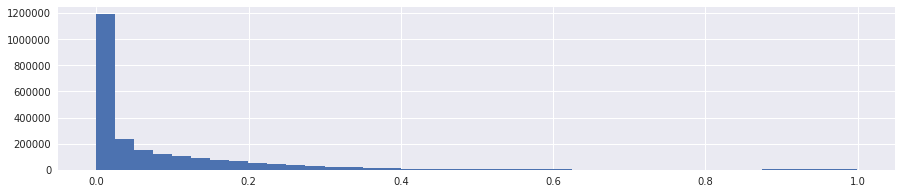

In [14]:
########### SECOND get test set features, predict, convert to 0.165, sanity check and submit

#test = pickle.load(open("dumps/testFeatures04-10.p", "rb" )) # maybe is already in mem?
Dtest = xgb.DMatrix(test[col].values,feature_names=col)
preds = bst.predict(Dtest)
predsConverted = convertPredictions(preds)

test["is_duplicate"] = pd.Series(predsConverted,index=test.index)
header = ["test_id", "is_duplicate"]
test.to_csv('submissions/predictions.csv', columns = header,index=False)

print("done")
plt.figure()
plt.hist(predsConverted,40)
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


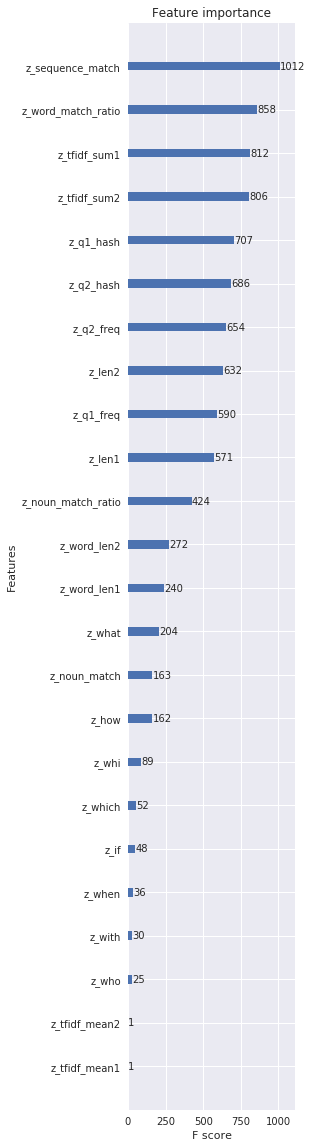

In [16]:
#check feature importance, needs DMAtrix trained xgboost because of feature names!!!!!!!
plt.rcParams['figure.figsize'] = (3, 20.0)
xgb.plot_importance(bst)
plt.show()